# Footprint AK batches of TOAs and SRLite and build VHR dataframes

In [64]:
import glob
from osgeo import gdal, ogr, osr
import geopandas as gpd
import pandas as pd
import sys, os
sys.path.append('/home/pmontesa/code/dgtools')
sys.path.append('/home/pmontesa/code/pygeotools')
import pygeotools 

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib

# This is a private repo
from dgtools.lib import dglib

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from scipy import ndimage

import contextily as ctx

*** With list of catids from some database search, run `EVHR` to get TOAs  


### Dirs

In [82]:
MAINDIR = '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1'
OUTDIR = '/explore/nobackup/people/pmontesa/srlite'

#TARGET = 'Alaska_ahri_20221004'
#TARGET_DIR_TOA = f'/explore/nobackup/projects/ilab/data/srlite/toa/{TARGET}'

TARGET = 'alaska_2nd_batch'
TARGET = 'alaska*'
TARGET_DIR_TOA = f'{MAINDIR}/toa/{TARGET}'

# Cloudmask dir
TARGET_DIR_CLOUDMASK = f'{MAINDIR}/cloudmask/{TARGET}'

# Final SRLite output
TARGET = 'alaska'
TARGET_DIR_SR = f'{MAINDIR}/srlite/{TARGET}'

# TOA: Build geodataframe of footprints
from huge Alaska request 

In [66]:
print(pd.Timestamp.now())
# Get footprints gdf from a target dir
TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
print(TARGET_DIR_TOA)

# Get the list of filenames
#SEARTH_STRING = '/*/*/5-toas/*toa.tif'
SEARTH_STRING = '/split_*/5-toas/*.xml'
SEARTH_STRING = '/**/*toa.xml'
#SEARTH_STRING = '/**/*M1BS*-toa.xml'

f_list_toa_xml = glob.glob(f"{TARGET_DIR_TOA}{SEARTH_STRING}", recursive=True)
print(f'Search returned {len(f_list_toa_xml)} TOA XMLs')

#f_list_toa = [f.replace('toa.xml', 'toa.tif') for f in f_list_toa_xml if os.path.getsize(f.replace('xml','tif')) > 0 and os.path.isfile(f.replace('xml','tif'))  ]
f_list_toa = [f.replace('toa.xml', 'toa.tif') for f in f_list_toa_xml if  os.path.isfile(f.replace('xml','tif'))  ]
print(f'Search returned {len(f_list_toa)} TOA XMLs with corresponding TIFs')


2023-08-29 13:36:19.351736
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/toa/alaska*
Search returned 3419 TOA XMLs
Search returned 3160 TOA XMLs with corresponding TIFs


In [67]:
f_list_toa[-1]

'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/toa/alaska_2nd_batch/split_10/WV03_20180609_M1BS_104001003E74F900-toa.tif'

In [68]:
from multiprocessing import Pool
from functools import partial

In [9]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list_toa)

CPU times: user 510 ms, sys: 219 ms, total: 728 ms
Wall time: 5.7 s


In [10]:
footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_toa = footprintlib.get_attributes_from_filename(footprint_gdf_toa, 'TOA', '-toa')
footprint_gdf_toa.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3154 entries, 0 to 3159
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            3154 non-null   object        
 1   geometry        3154 non-null   geometry      
 2   footprint_name  3154 non-null   object        
 3   path            3154 non-null   object        
 4   area_km2        3154 non-null   float64       
 5   area_ha         3154 non-null   float64       
 6   type            3154 non-null   object        
 7   catid           3154 non-null   object        
 8   sensor          3154 non-null   object        
 9   year            3154 non-null   int64         
 10  month           3154 non-null   int64         
 11  date            3154 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(2), object(6)
memory usage: 320.3+ KB


## TOA data for all of Alaska

<AxesSubplot: >

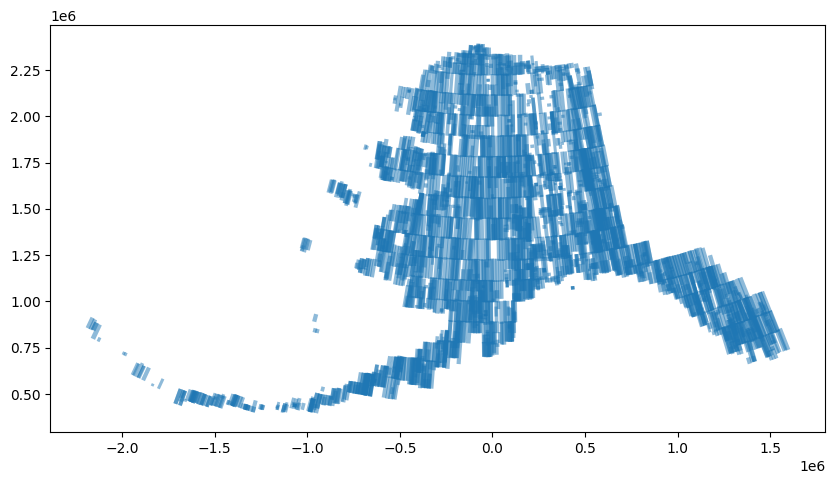

In [11]:
footprint_gdf_toa.to_crs(3338).plot(figsize=(10,10), alpha=0.5) #

In [12]:
footprint_gdf_toa.head()

,file,geometry,footprint_name,path,area_km2,area_ha,type,catid,sensor,year,month,date
0,WV02_20130707_M1BS_1030010024338600-toa.tif,"POLYGON ((-129.21761 55.95624, -129.22384 57.0...",WV02_20130707_M1BS_1030010024338600,/explore/nobackup/projects/ilab/data/srlite/pr...,2189.827944,218982.7944,TOA,1030010024338600,WV02,2013,7,2013-07-07
1,WV02_20130714_M1BS_103001002503EF00-toa.tif,"POLYGON ((-130.93496 55.94863, -130.99172 57.0...",WV02_20130714_M1BS_103001002503EF00,/explore/nobackup/projects/ilab/data/srlite/pr...,2946.255180,294625.5180,TOA,103001002503EF00,WV02,2013,7,2013-07-14
2,WV02_20130714_M1BS_10300100252F2900-toa.tif,"POLYGON ((-131.21966 55.95564, -131.28334 57.0...",WV02_20130714_M1BS_10300100252F2900,/explore/nobackup/projects/ilab/data/srlite/pr...,2917.563440,291756.3440,TOA,10300100252F2900,WV02,2013,7,2013-07-14
3,WV02_20130718_M1BS_1030010025958C00-toa.tif,"POLYGON ((-130.56024 56.95492, -130.60711 58.0...",WV02_20130718_M1BS_1030010025958C00,/explore/nobackup/projects/ilab/data/srlite/pr...,3202.375820,320237.5820,TOA,1030010025958C00,WV02,2013,7,2013-07-18
4,WV02_20130912_M1BS_1030010025674800-toa.tif,"POLYGON ((-128.95965 53.93621, -128.95854 55.0...",WV02_20130912_M1BS_1030010025674800,/explore/nobackup/projects/ilab/data/srlite/pr...,2889.244400,288924.4400,TOA,1030010025674800,WV02,2013,9,2013-09-12


## Make a dictionary of VHR metadata
Use dgtools to pull out metadata for list of TOAs in a dir

### Get the VHR metadata for the big Alaska set of TOAs

In [ ]:
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')

In [83]:
%%time

import importlib
importlib.reload(vhrlib)

with Pool(processes=35) as pool:
    vhr_df_list = pool.map(partial(vhrlib.make_vhr_xml_dataframe), f_list_toa_xml)
vhr_df = pd.concat(vhr_df_list)
vhr_df.info()

vhr_df.to_csv(f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/tables/vhr_toa_metadata_{TARGET}_{nowtime}.csv')

CPU times: user 72.3 ms, sys: 1.21 ms, total: 73.5 ms
Wall time: 84.8 ms


### Show acquisition geometry 

In [14]:
# Prefer to join VHR df to my footprints
footprints_vhr_meta_gdf = pd.merge(footprint_gdf_toa, vhr_df[['satid','catid', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'catid', copy=False)

In [15]:
footprints_vhr_meta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3160 entries, 0 to 3159
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            3160 non-null   object        
 1   geometry        3160 non-null   geometry      
 2   footprint_name  3160 non-null   object        
 3   path            3160 non-null   object        
 4   area_km2        3160 non-null   float64       
 5   area_ha         3160 non-null   float64       
 6   type            3160 non-null   object        
 7   catid           3160 non-null   object        
 8   sensor          3160 non-null   object        
 9   year            3160 non-null   int64         
 10  month           3160 non-null   int64         
 11  date            3160 non-null   datetime64[ns]
 12  satid           3160 non-null   object        
 13  el              3160 non-null   float64       
 14  az              3160 non-null   float64       
 

<AxesSubplot: >

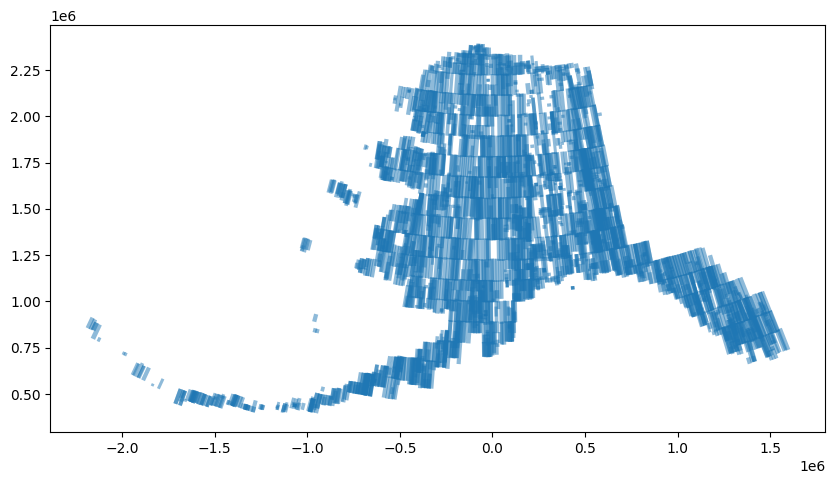

In [16]:
footprint_gdf_toa.to_crs(3338).plot(figsize=(10,10), alpha=0.5) #

## Save TOA footprints for CCDC creation

In [9]:
out_gdf_fn = f'{OUTDIR}/footprints_vhrmeta_toa_{TARGET}.gpkg'

In [17]:
footprints_vhr_meta_gdf.to_file(out_gdf_fn, driver='GPKG')
footprints_vhr_meta_gdf.drop(columns=['date']).to_file(out_gdf_fn.replace('gpkg','shp'))
out_gdf_fn

/tmp/ipykernel_758317/1080285615.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  footprints_vhr_meta_gdf.drop(columns=['date']).to_file(out_gdf_fn.replace('gpkg','shp'))


'/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_toa_alaska.gpkg'

## Read back in the TOA footprints file

In [13]:
import importlib
importlib.reload(footprintlib)
importlib.reload(vhrlib)

<module 'vhrlib' from '/panfs/ccds02/home/pmontesa/code/geoscitools/vhrlib.py'>

In [10]:
footprints_vhr_meta_gdf = gpd.read_file(out_gdf_fn)

<AxesSubplot: >

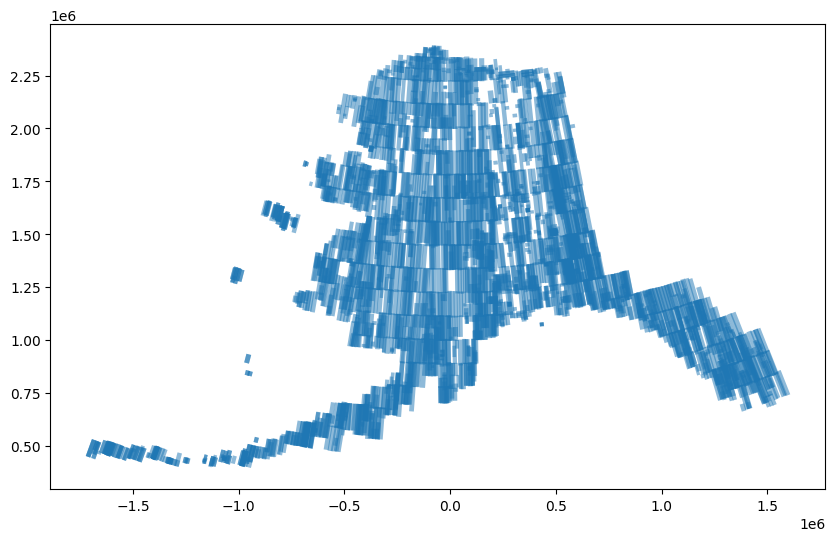

In [142]:
footprints_vhr_meta_gdf.cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,10), alpha=0.5) 

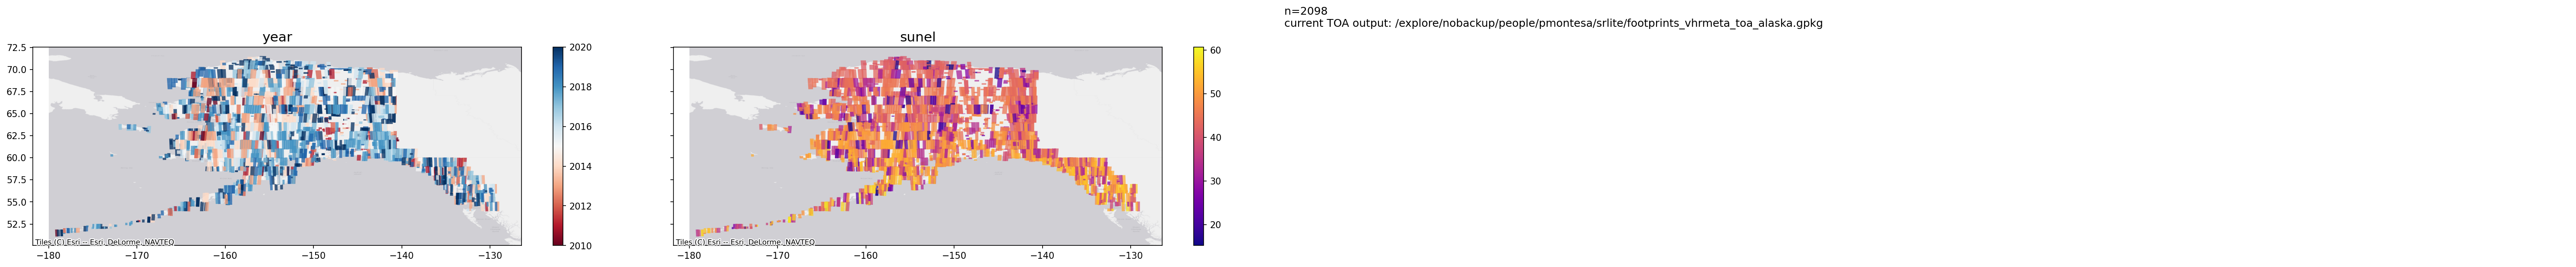

In [22]:
#MAP_SUBPLOTS(footprints_vhr_meta_gdf.cx[-180:-125,50:75], out_gdf_fn)
vhrlib.MAP_SUBPLOTS(footprints_vhr_meta_gdf.cx[-180:-125,50:75], f'\ncurrent TOA output: {out_gdf_fn}', col_list = ['year', 'sunel'], categorical_list=[False, False])

# SRlite: Build footprints geodataframe 

In [4]:
# Get footprints gdf from a target dir
TARGET_DIR_SR = TARGET_DIR_SR.rstrip('/')
print(TARGET_DIR_SR)

f_list_sr_dict = dict()
BATCH_LIST = ['batch_1', 'batch_2']

for BATCH in BATCH_LIST:
    # Get the list of filenames
    #SEARTH_STRING = '/*/*/5-toas/*toa.tif'
    SEARTH_STRING_4band = f'/{BATCH}/4_band*/**/*sr-02m.tif'
    SEARTH_STRING_8band = f'/{BATCH}/8_band*/**/*sr-02m.tif'

    for SEARTH_STRING in [SEARTH_STRING_4band, SEARTH_STRING_8band]:

        f_list_sr = glob.glob(f"{TARGET_DIR_SR}{SEARTH_STRING}", recursive=True)
        #f_list_sr = [os.path.basename(x) for x in f_list_sr]
        f_list_sr_dict.update([(SEARTH_STRING, f_list_sr)])
        print(f'Search returned for {SEARTH_STRING}: {len(f_list_sr)} SRs')

/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska
Search returned for /batch_1/4_band*/**/*sr-02m.tif: 2237 SRs
Search returned for /batch_1/8_band*/**/*sr-02m.tif: 1917 SRs
Search returned for /batch_2/4_band*/**/*sr-02m.tif: 0 SRs
Search returned for /batch_2/8_band*/**/*sr-02m.tif: 988 SRs


### Get full list of SRlite across all batches

In [26]:
f_list_sr_FULL = []
for k,v in f_list_sr_dict.items():
    f_list_sr_FULL += v

In [27]:
%%time
# Make footprint gdfs of the the filenames, concat to single gdf
if True:
    f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_sr_FULL]
else:
    with Pool(processes=35) as pool:
        f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list_sr_FULL)

CPU times: user 1min 5s, sys: 6.53 s, total: 1min 12s
Wall time: 2min 41s


In [33]:
footprint_gdf_sr = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_sr.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5087 entries, 0 to 5086
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            5087 non-null   object  
 1   geometry        5087 non-null   geometry
 2   footprint_name  0 non-null      object  
 3   path            5087 non-null   object  
 4   area_km2        5087 non-null   float64 
 5   area_ha         5087 non-null   float64 
dtypes: float64(2), geometry(1), object(3)
memory usage: 278.2+ KB


In [34]:
footprint_gdf_sr.head()

,file,geometry,footprint_name,path,area_km2,area_ha
0,WV03_20190501_M1BS_104001004B842400-sr-02m.tif,"POLYGON ((-175.54404 51.67185, -175.52432 52.2...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1196.757252,119675.7252
1,WV02_20101003_M1BS_103001000772AA00-sr-02m.tif,"POLYGON ((-178.91320 51.09154, -178.94674 51.8...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1953.551432,195355.1432
2,WV03_20181001_M1BS_10400100422A1F00-sr-02m.tif,"POLYGON ((-174.09425 51.97704, -174.05825 52.5...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1174.448128,117444.8128
3,WV03_20181001_M1BS_1040010043958A00-sr-02m.tif,"POLYGON ((-174.29843 51.98034, -174.26614 52.5...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1052.535344,105253.5344
4,WV02_20120802_M1BS_103001001A3DFF00-sr-02m.tif,"POLYGON ((-178.04420 51.44267, -178.05793 52.0...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1395.669060,139566.9060


In [35]:
#footprint_gdf_sr.groupby('path').aggregate({ 'path':'count'})
footprint_gdf_sr['subdir'] = footprint_gdf_sr['path'].str.split(TARGET_DIR_SR, expand=True)[1]#.str.split('/split', expand=True)[0]
footprint_gdf_sr.head()

,file,geometry,footprint_name,path,area_km2,area_ha,subdir
0,WV03_20190501_M1BS_104001004B842400-sr-02m.tif,"POLYGON ((-175.54404 51.67185, -175.52432 52.2...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1196.757252,119675.7252,/batch_1/4_band/split_10
1,WV02_20101003_M1BS_103001000772AA00-sr-02m.tif,"POLYGON ((-178.91320 51.09154, -178.94674 51.8...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1953.551432,195355.1432,/batch_1/4_band/split_10
2,WV03_20181001_M1BS_10400100422A1F00-sr-02m.tif,"POLYGON ((-174.09425 51.97704, -174.05825 52.5...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1174.448128,117444.8128,/batch_1/4_band/split_10
3,WV03_20181001_M1BS_1040010043958A00-sr-02m.tif,"POLYGON ((-174.29843 51.98034, -174.26614 52.5...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1052.535344,105253.5344,/batch_1/4_band/split_10
4,WV02_20120802_M1BS_103001001A3DFF00-sr-02m.tif,"POLYGON ((-178.04420 51.44267, -178.05793 52.0...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,1395.669060,139566.9060,/batch_1/4_band/split_10


## Drop duplicates in complete set of srlite across all alaska batches

In [36]:
footprint_gdf_sr = footprintlib.get_attributes_from_filename(footprint_gdf_sr, 'SR', '-sr', DROP_FILE_DUPLICATES=True)
footprint_gdf_sr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2956 entries, 124 to 5086
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            2956 non-null   object        
 1   geometry        2956 non-null   geometry      
 2   footprint_name  2956 non-null   object        
 3   path            2956 non-null   object        
 4   area_km2        2956 non-null   float64       
 5   area_ha         2956 non-null   float64       
 6   subdir          2956 non-null   object        
 7   type            2956 non-null   object        
 8   catid           2956 non-null   object        
 9   sensor          2956 non-null   object        
 10  year            2956 non-null   int64         
 11  month           2956 non-null   int64         
 12  date            2956 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(2), object(7)
memory usage: 323.3+ KB


<AxesSubplot: >

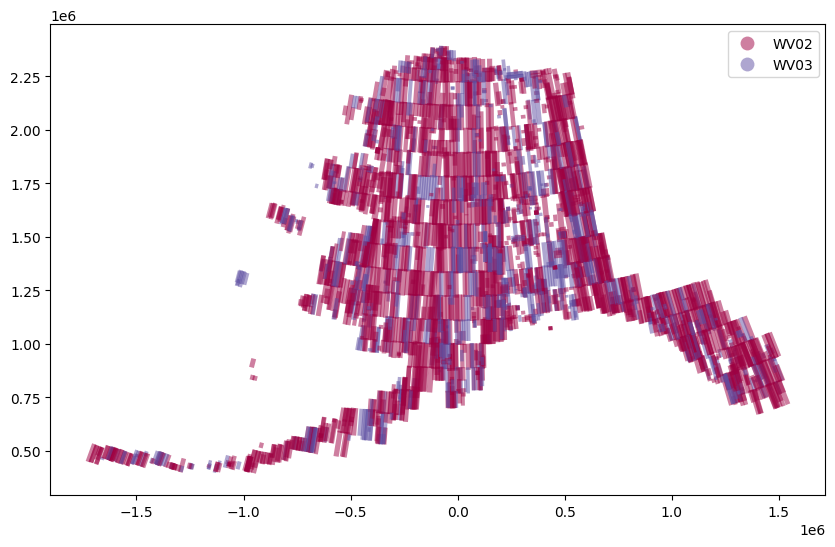

In [37]:
footprint_gdf_sr.cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,10), alpha=0.5, column='sensor', cmap='Spectral', legend=True) 

In [39]:
footprint_gdf_sr.groupby('path').aggregate({'path':'count'})

,path
path,
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/4_band/split_3,1
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/4_band/split_5,1
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/4_band/split_6,1
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/4_band_csv,162
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_10,23
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_2,52
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_3,149
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_4,259
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_5,257


In [40]:
out_gdf_SR_fn = f'{OUTDIR}/footprints_vhrmeta_SR_{TARGET}.gpkg'

if True:
    # Prefer to join VHR df to my footprints
    footprints_vhr_meta_SR_gdf = pd.merge(footprint_gdf_sr, vhr_df[['satid','catid', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'catid', copy=False)
    print( f"# {TARGET} images with metadata: {footprints_vhr_meta_SR_gdf.shape[0]}")
    footprints_vhr_meta_SR_gdf.to_file(out_gdf_SR_fn, driver='GPKG')
    footprints_vhr_meta_SR_gdf.drop(columns=['date']).to_file(out_gdf_SR_fn.replace('gpkg','shp'))
else:
    print( f"# {TARGET} images without metadata: {footprint_gdf_sr.shape[0]}")
    footprint_gdf_sr.head()


out_gdf_SR_fn

# alaska images with metadata: 2963


/tmp/ipykernel_758317/2251047476.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  footprints_vhr_meta_SR_gdf.drop(columns=['date']).to_file(out_gdf_SR_fn.replace('gpkg','shp'))


'/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_SR_alaska.gpkg'

In [27]:
footprints_vhr_meta_SR_gdf = gpd.read_file(f'{OUTDIR}/footprints_vhrmeta_SR_alaska.gpkg')

In [54]:
footprints_vhr_meta_SR_gdf['fn'] = footprints_vhr_meta_SR_gdf['path'].astype(str) + '/' + footprints_vhr_meta_SR_gdf['file'].astype(str)

In [ ]:
cols_list = ['month', 'sunel', 'sunaz', 'el', 'az']
cmap_list = ['Spectral', 'plasma','magma','viridis','inferno']
for i, col in enumerate(cols_list):
    ax = footprints_vhr_meta_SR_gdf.cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,5), alpha=0.5, column=cols_list[i], cmap=cmap_list[i], legend=True) 
    ax.set_title("SRlite " + cols_list[i])

In [ ]:
#vhrlib.MAP_SUBPLOTS(footprints_vhr_meta_SR_gdf.cx[-180:-125,50:75].to_crs(3338), f'\ncurrent SRlite output: {out_gdf_SR_fn}', col_list = ['year', 'sunel'], categorical_list=[False, False])

# Footprint the cloudmask
To really know where valid data from SRlite exists, footprint the cloudmask

In [6]:
import importlib
import footprintlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/panfs/ccds02/home/pmontesa/code/geoscitools/footprintlib.py'>

In [7]:
CLOUDDIR = os.path.join(MAINDIR, 'cloudmask')

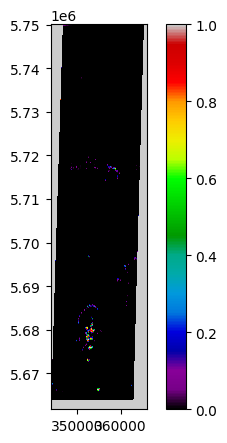

In [8]:
import rasterio as rio
from rasterio.crs import CRS
from rasterio.plot import show_hist, show
vhrlib.map_image_band('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask/split_10/WV02_20101003_M1BS_103001000772AA00-toa.cloudmask.tif', band_num=1, vmin=0, vmax=1)

In [8]:
# Get footprints gdf from a target dir
TARGET_CLOUDDIR = CLOUDDIR.rstrip('/')
print(TARGET_CLOUDDIR)

# Get the list of filenames
#SEARTH_STRING = '/*/*/5-toas/*toa.tif'
SEARTH_STRING = '/split_*/*cloudmask.tif'

f_list_cloudmask = glob.glob(f"{TARGET_CLOUDDIR}{SEARTH_STRING}", recursive=True)
print(f'Search returned {len(f_list_cloudmask)} cloudmasks')

/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask
Search returned 2107 cloudmasks


In [9]:
# # Make footprint gdfs of the the filenames, concat to single gdf
# f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=True, MASK_OUT_VALUE=255, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_cloudmask[0:1]]
# footprint_gdf_cloudmask = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)

## Return a GDF of the SRLite areas of good pixels
resulting from a dilation of the cloudmask that will permit tiles of size N_ITER x 2

In [10]:
LAND_VAL = 0
CLOUD_VAL = 1
N_ITER=128
TARGET

'alaska'

#### Get the list of strip names from the paths of SRLite

In [13]:
stripname_list = [os.path.basename(f).split('-sr')[0] for f in f_list_sr]
print(len(stripname_list))
stripname_list[0]


2075


'WV02_20170828_M1BS_103001006E044100'

#### Get the list of paths to cloudmasks that correspond to strip names from the paths of SRLite

In [14]:
f_list_cloudmask_final = [cloudmask for cloudmask in f_list_cloudmask for stripname in stripname_list if stripname in cloudmask]
print(len(f_list_cloudmask_final))
f_list_cloudmask_final[0]

2079


'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask/split_2/WV02_20100726_M1BS_1030010005C35F00-toa.cloudmask.tif'

In [15]:
# Get missing
list_footprints_cloudmask_finished = [os.path.basename(f).split('-toa.cloudmask')[0] for f in glob.glob(os.path.join(OUTDIR, 'tmp') + '/*.gpkg' )]
print(len(list_footprints_cloudmask_finished))
print(list_footprints_cloudmask_finished[0])

#list_footprints_cloudmask_missing = [stripname for stripname in stripname_list if stripname not in list_footprints_cloudmask_finished]
list_footprints_cloudmask_missing = [r_fn for r_fn in f_list_cloudmask_final if os.path.basename(r_fn).split('-toa.cloudmask')[0] not in list_footprints_cloudmask_finished]

print(len(list_footprints_cloudmask_missing))
print(list_footprints_cloudmask_missing[0])

2072
WV02_20100726_M1BS_1030010005C35F00
1
/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/cloudmask/split_6/WV02_20170928_M1BS_103001007388B900-toa.cloudmask.tif


### Multiprocess indiv cloudmask GDFs

In [ ]:
if True:
    f_gdf_lst = [footprintlib.footprint_cloudmask(r_fn, CLOUD_VAL, INVERT=False, N_ITER=N_ITER, OUTDIR=os.path.join(OUTDIR, 'tmp')) for r_fn in list_footprints_cloudmask_missing]
else:
    from multiprocessing import Pool
    from functools import partial

    with Pool(processes=30) as pool:
        pool.map(partial(footprintlib.footprint_cloudmask, NEW_NDV=CLOUD_VAL, INVERT=False, N_ITER=N_ITER, OUTDIR=os.path.join(OUTDIR, 'tmp')), list_footprints_cloudmask_missing)

### Build a single GDF of all indiv cloudmask footprints for SRLite

In [ ]:
f_gdf_lst = [ gpd.read_file(footprint_fn) for footprint_fn in glob.glob(os.path.join(OUTDIR, 'tmp')+'/*gpkg')]

In [ ]:
footprint_gdf_cloudmask = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)

In [ ]:
out_gdf_SR_CLOUDMASK_fn = f'{OUTDIR}/footprints_vhr_SR_CLOUDMASK_{TARGET}.gpkg'
footprint_gdf_cloudmask.to_file(out_gdf_SR_CLOUDMASK_fn, driver='GPKG')

In [ ]:
footprint_gdf_cloudmask.boundary.plot()
#footprint_gdf_cloudmask[footprint_gdf_cloudmask.raster_val==0].plot()

In [ ]:
footprint_gdf_cloudmask

In [ ]:
footprint_gdf_cloudmask.plot(column='file')